# Efficient coding

In this notebook the _Efficient coding_-networks needed for Figure 2 are run. Developed for Julia 0.6.1.

In [1]:
using PyPlot
using ProgressMeter
using PyCall

In [2]:
N = 1000
D = 2
gamma = 0.2*randn(N,D);

The simulation for efficient coding is currently merged with the specific task used in the paper. It should be split into a simulator part and a task-running part.

In [3]:
function runEC(gamma)
    N,D = size(gamma)
    mu = 1e-6
    lambda_d = 50
    lambda_v = 20
    sigma_v = 1e-5
    v = 1e-3
    Th = 0.5 * (v*lambda_d + mu*lambda_d^2 + sum(gamma.^2, 2))
    dt = 1e-4
    T = Int(2.5 / dt)
    signal = [0.2 0.6 0.0 -0.7 -0.2; 0.0 -0.3 0.2 0.0 0.5];
    V = zeros(T, N);
    I = zeros(T, N);
    spikes = Vector{Tuple{Float64, Int}}()
    readout = zeros(T, D);
    @showprogress 1 "Simulating" for t=2:T
        input = t % 5000 > 1000 ? readout[t-1, :] : signal[:, min(div(t, 5000), 4) + 1]*100
        V[t,:] = (1-dt*lambda_v)*V[t-1,:] + lambda_d*dt*gamma*input
        I[t,:] = (1-dt*lambda_d)*I[t-1,:]
        while true
            noSpikes = true
            for i=randperm(N)
                if V[t, i] > Th[i]
                    V[t,:] -= gamma*gamma[i,:]
                    V[t,i] -= mu*lambda_d^2
                    I[t,i] += 1
                    push!(spikes, (t*dt, i))
                    noSpikes = false
                end
            end
            if noSpikes
                break
            end
        end
        readout[t, :] = gamma'*I[t,:]
    end
    return readout, spikes
end

runEC (generic function with 1 method)

Run the network

In [4]:
readout, spikes = runEC(gamma);

Simulating100%|█████████████████████████████████████████| Time: 0:00:12


Check that the decoded signals appear to be reasonable

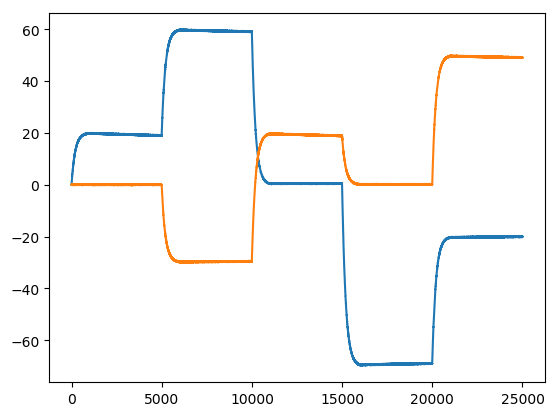

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f5525f88990>

In [17]:
plot(readout[:, 1])
#step((1:5)*5000, signal[1,:]*100)
plot(readout[:, 2])
#step((1:5)*5000, signal[2,:]*100)

Checking the spikes so that the firing rates are reasonable.

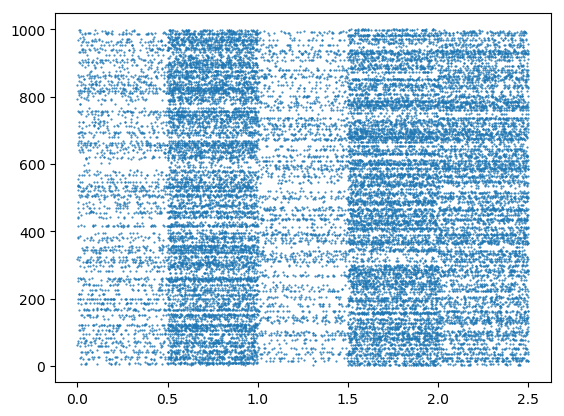

(26146,)


1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f55042c37d0>

In [18]:
println(size(spikes))
plot(getindex.(spikes, 1), getindex.(spikes, 2), ".", ms=1)
#ylim(0,100)

In [19]:
filename = "../generatedData/fig2.h5"

"../generatedData/fig2.h5"

In [20]:
@pyimport pandas

In [21]:
pandas.DataFrame(spikes, columns=["time", "neuron"])[:to_hdf](filename, "ec/original/spikes")
pandas.DataFrame(readout, columns=["x1", "x2"])[:to_hdf](filename, "ec/original/x")
pandas.DataFrame(gamma, columns=["K1", "K2"])[:to_hdf](filename, "ec/original/K")
pandas.DataFrame(50*gamma, columns=["phi1", "phi2"])[:to_hdf](filename, "ec/original/phi")

The perturbed network

In [22]:
readout, spikes = runEC(gamma[:,[2,1]]);

Simulating100%|█████████████████████████████████████████| Time: 0:00:10


In [23]:
pandas.DataFrame(spikes, columns=["time", "neuron"])[:to_hdf](filename, "ec/perturbed/spikes")
pandas.DataFrame(readout, columns=["x1", "x2"])[:to_hdf](filename, "ec/perturbed/x")
pandas.DataFrame(gamma[:,[2,1]], columns=["K1", "K2"])[:to_hdf](filename, "ec/perturbed/K")
pandas.DataFrame(50*gamma[:,[2,1]], columns=["phi1", "phi2"])[:to_hdf](filename, "ec/perturbed/phi")